# Testing the Imaging Level 3 Pipeline

Testing the imaging level 3 pipeline is done using two Mirage simulations. Each input simulated exposure is a four-point dithered observation in a single NIRISS filter, F158M.  The observation is a copy of one of the verification observations in the NIRISS Focus CAR 1085.

The simulations are done with a special set of input simulated dark ramps and "clean" reference files.  The goal of using these files in place of the usual CV3 darks and the normal pipeline reference files is to eliminate the bad pixels.  The input simulated darks are produced by an adapted version of the NGHXRG code originally produced by Bernie Rauscher.  The original code is described in Rauscher, B. J., 2015, PASP, 127, 1144. Some additional functionality has been added by Kevin Volk for this particular version of the code:  primarily the channel-to-channel random offsets and a per-read dark signal.  Along with the simulated darks that do not have the void structure, the Mirage simulations use featureless gain and flat field reference files, the pedestal appropriate to the dark current simulation, and a bad pixel mask with no flags for bad pixels (only the flag for the reference pixels is set).

The simulated data is not produced here as it takes a while to run and some steps in the production were done manually.  The simulated data is found in box at https://stsci.app.box.com/folder/118432734499 in the simple_dithered_imaging_example3 directory and the complex_dithered_imaging_example directory. If one wishes to regenerate these Mirage files one needs the contents of four directories on box:  simple_dithered_imaging_example3, complex_dithered_imaging_example, simulated_reference_files, and simdarks.  All these files are in the box repository.  For running the notebook, one only needs the simple_dithered_imaging_example3 and complex_dithered_imaging_example directories.

**The notebook assumes that you are running it in the parent directory under which the two simulations directories are stored.**

Here I describe how the simple imaging simulation was made.  The same process applies for the complex imaging simulation in the other directory.

The files were originally produced at 

/ifs/jwst/wit/niriss/kevin/simple_dithered_imaging_example3

where they can be found along with the pipeline output files.  The general outline of the steps to produce the files is:

(a) Use Mirage to produce the .yaml input files from an APT file.  This is done with the generate_yaml_files.py code.

(b) Revise the .yaml files to use the non-CRDS reference files and the simulated dark current ramps, via fix_yaml.py.

(c) Make perturbed pointing .yaml files from the original file jw01085002001_01101_00002_nis.yaml.  The new .yaml files are named jw01085002001_01101_00002_nis_alt1.yaml, jw01085002001_01101_00002_nis_alt2.yaml, and jw01085002001_01101_00002_nis_alt3.yaml.  The files have slightly changed rotation, RA, and Dec parameters respectively.  The output file names are also adjusted.  The edits were done by hand.

(d) Run Mirage to generate the simulated raw data files.  This is done via a command such as

runmodels.py jw*.yaml

in the above directory.

(e) Fix the headers in the "alt" position 2 uncal files.  One needs to first copy the three alt uncal files to save them in case they are needed later (see "rename_uncals.ec") and then run a script to adjust the headers to be the same as the original simulation of the dither position.  The latter step is done via update_headers.py.

(f) To facilitate running the pipeline directories "run1" to "run4" were created.  In each directory links are made back up to the upper level "uncal" files.  Directory run1 has the original unperturbed Mirage simulations linked.  The other directories run2 to run4 each have the second dither position file name jw01085002001_01101_00002_nis_uncal.fits linked to one of the jw01085002001_01101_00002_nis_alt1_uncal.fits type files.

(g) In each of the four sub-directories bring in the pipeline .cfg file set via the command

collect_pipeline_cfgs .

Along with the normal set of .cfg files the logging configuration file stpipe-log.cfg is added to each directory to tell the pipeline to write the log information to "pipeline.log".  The file has the form

```
[*]
handler = file:pipeline.log
level = INFO
```

(h) Run the pipeline for each sub-set of four input raw data files.  This is done using the run_pipeline_simulated_files.py code.  One needs to use this version because the calls need to override a number of the normal reference files to match the input simulation properly.  The script runs the sets of four files through the pipeline levels detector1, image2, and image3.

The input scene has 10 stars of nominally identical brightness distributed over the image.  There is a uniform background  signal defined by the medum background estimated for the position of concern.  There are no extended sources in the field, only the 10 point sources.  Each observation is a single exposure of 10 groups in NISRAPID read-out. 

In [1]:
# general Python packages needed here
from astropy.coordinates import SkyCoord
from ci_watson.artifactory_helpers import get_bigdata
import glob
import math
import matplotlib
import matplotlib.pyplot as pyplot
import numpy
import os
import sys

In [3]:
# the STScI packages of interest
from astropy.io import fits
import jwst
#import mirage

To run the models and the pipeline requires both Mirage and the JWST pipeline.  Check the versions of both these packages.

In [3]:
mirage.__version__

'1.3.4.dev114+g4006253'

In [4]:
jwst.__version__

'0.17.1'

## Load data files

In [5]:
# Use get_bigdata to get files from artifactory

file1 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'image3',
                     'image3_niriss_test', 
                     'jw01085002001_01101_00001_nis_simple_rate.fits')

file2 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'image3',
                     'image3_niriss_test', 
                     'jw01085002001_01101_00001_nis_uncal_F158M_final_seed_image.fits')

file3 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'image3',
                     'image3_niriss_test', 
                     'jw01085002001_01101_00001_nis_simple_i2d.fits')

file4 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'image3',
                     'image3_niriss_test', 
                     'jw01085002001_01101_00001_nis_simple_combined_i2d.fits')

catalog1 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'image3',
                     'image3_niriss_test', 
                     'jw01085002001_01101_00001_nis_simple_combined_cat.ecsv')

file5 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'image3',
                     'image3_niriss_test', 
                     'jw01085002001_01101_00001_nis_complex_i2d.fits')

pointsourcelist = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'image3',
                     'image3_niriss_test', 
                     'jw01085002001_01101_00001_nis_complex_uncal_pointsources.list')

file6 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'image3',
                     'image3_niriss_test', 
                     'jw01085002001_01101_00001_nis_complex_combined_i2d.fits')


The following shows one of the output ramp slope images from the simulation.


In [5]:
#path = './simple_dithered_imaging_example3/run1/'
#filename = 'jw01085002001_01101_00001_nis_rate.fits'




Define some subroutines of interest.


In [6]:
# The following was copied from astropy with small changes in the passing of parameters and leaving "values" unchanged.

def get_limits(values, nsamples=1000, contrast=0.25, max_reject=0.5,
               min_npixels=5, krej=2.5, max_iterations=5):
    """
    Find the IRAF-like "zscale" signal limits for an image.

    This routine is copied from astropy.visualization.  The astropy routine is
    part of an object, so is was needful that it to be a subroutine here.
    Aside from a change to the passing of the arguments and removing "self."
    the code has not been changed.  The original code is part of
    ZScaleInterval.  It is a recoding of the IRAF zscale algorithm in python.

    All parameters except the input image array are optional.

    Parameters
    ----------
    values :   a two-dimensional numpy array for which the zscale limit
               values are to be calculated.  Can be float or integer values.

    nsamples : the number of pixels to use to estimate the median and the
               range (integer).

    contrast : The constrast parameter from IRAF imexam which controls the
               range of values considered to estimate the minimum and maximum
               values to use in the display, a real value between 0.0 and 1.0

    max_reject : Parameter for the maximum fraction of rejected pixels,
                 a real values between 0.0 and 1.0; if more than this
                 fraction of pixels are rejected then the full range
                 of the data values is returned.

    min_npixels : An integer value for the minimum number of pixels that
                  are rejected by the iterative algorithm; if less than
                  this number of pixels is rejected the full data range is
                  returned.

    krej :  A float value, The number of standard deviations used for
            rejection.  It must be positive.

    max_iterations : An integer value giving the maximum number of rejection
                     iterations to use.

    Returns
    -------
    vmin :  the minimum value for the zscale range, a real number

    vmax :  the maximum value for the zscale range, a real number

    """
    # Sample the image
    newvalues = numpy.asarray(values)
    newvalues = newvalues[numpy.isfinite(newvalues)]
    stride = int(max(1.0, newvalues.size / nsamples))
    samples = newvalues[::stride][:nsamples]
    samples.sort()

    npix = len(samples)
    vmin = samples[0]
    vmax = samples[-1]

    # Fit a line to the sorted array of samples
    minpix = max(min_npixels, int(npix * max_reject))
    xvalues = numpy.arange(npix)
    ngoodpix = npix
    last_ngoodpix = npix + 1

    # Bad pixels mask used in k-sigma clipping
    badpix = numpy.zeros(npix, dtype=bool)

    # Kernel used to dilate the bad pixels mask
    ngrow = max(1, int(npix * 0.01))
    kernel = numpy.ones(ngrow, dtype=bool)

    for niter in range(max_iterations):
        if ngoodpix >= last_ngoodpix or ngoodpix < minpix:
            break

        fit = numpy.polyfit(xvalues, samples, deg=1, w=(~badpix).astype(int))
        fitted = numpy.poly1d(fit)(xvalues)

        # Subtract fitted line from the data array
        flat = samples - fitted

        # Compute the k-sigma rejection threshold
        threshold = krej * flat[~badpix].std()

        # Detect and reject pixels further than k*sigma from the
        # fitted line
        badpix[(flat < - threshold) | (flat > threshold)] = True

        # Convolve with a kernel of length ngrow
        badpix = numpy.convolve(badpix, kernel, mode='same')

        last_ngoodpix = ngoodpix
        ngoodpix = numpy.sum(~badpix)

    slope, intercept = fit

    if ngoodpix >= minpix:
        if contrast > 0:
            slope = slope / contrast
        center_pixel = (npix - 1) // 2
        median = numpy.median(samples)
        vmin = max(vmin, median - (center_pixel - 1) * slope)
        vmax = min(vmax, median + (npix - center_pixel) * slope)

    return vmin, vmax


def log_transform(image, zmin, zmax):
    """
    Apply an IRAF-style logarithmic image transformation.

    This routine takes an input image and maps the values to a relative
    scale in a way similar to what the IRAF log display function does.
    The specified image intensity range is mappped to relative values
    from 1 to 1000.  The code takes the new image and displays it on
    a logarithmic scale, but the values are left in the range from 1
    to 1000.

    Parameters
    ----------
        image :   A numpy two-dimensional array of values.

        zmin :    A real value for the minimum level to display in the
                  new image

        zmax :    A real value for the maximum level to display in the
                  new image

    Returns
    -------
        newimage :  An image of the same dimensions as the input image,
                    with the relative scaling from 1 to 1000.

        transvalues : A two-element list of floating point values, the
                      minimum and maximum values for the transformation.

    """
    newimage = numpy.copy(image)
    newimage[newimage < zmin] = zmin
    newimage[newimage > zmax] = zmax
    zrange = zmax - zmin
    newimage = 1. + 999.*(image - zmin)/zrange
    newimage = numpy.log10(newimage)
    transvalues = [zmin, zmax]
    return newimage, transvalues


def sqrt_transform(image, zmin, zmax, clip=False):
    """
    Apply a square-root transformation to an image.

    This routine takes an input image and a range, and then creates a
    new image with square-root scaling.  Any negative values are scaled
    to the square-root of the absolute value and then made negative
    again, so the square-root scaling applies to both the positive
    and negative values separately.

    Parameters
    ----------
        image :   A numpy two-dimensional array of values.

        zmin :    A real value for the minimum level to display in the
                  new image, if the clip flag is True

        zmax :    A real value for the maximum level to display in the
                  new image, if the clip flag is True

        clip :    A optional boolean flag for whether the zmin and zmax values
                  are applied.  The zmin and zmax parameters are present to
                  be consistent with the calls to the logarithmic
                  transformation.

    Returns
    -------
        newimage :  An image of the same dimensions as the input image,
                    with the two-side square-root scaling.

        transvalues : A two-element list of floating point values, the
                      minimum and maximum values for the transformation.

    """
    newimage = numpy.sqrt(numpy.abs(image))
    newimage[image < 0.] = -1.*newimage[image < 0.]
    transvalues = [numpy.min(image), numpy.max(image)]
    if clip:
        newzmin = math.sqrt(abs(zmin))
        if zmin < 0.:
            newzmin = -1.*newzmin
        newzmax = math.sqrt(abs(zmax))
        if zmax < 0.:
            newzmax = -1.*newzmax
        newimage[newimage < newzmin] = newzmin
        newimage[newimage > newzmax] = newzmax
        if newzmax < newzmin:
            temp = (newzmax, newzmin)
            (newzmin, newzmax) = temp
        transvalues = [zmin, zmax]
    return newimage, transvalues


In [7]:
def show_image(imagename, next=1, zscale=False, nsamples=1000, display='linear'):
    image = fits.getdata(imagename, ext=next)
    if zscale:
        zmin, zmax = get_limits(image, nsamples=nsamples)
    else:
        zmin = numpy.min(image)
        zmax = numpy.max(image)
        if 'log' in display:
            oldimage = numpy.copy(image)
            image, newrange = log_transform(oldimage, zmin, zmax)
            zmin = newrange[0]
            zmax = newrange[1]
    pyplot.figure(figsize=(9., 9.))
    pyplot.imshow(image, vmin=zmin, vmax=zmax, origin='lower', cmap='jet')
    print('Range: %f to %f' % (zmin, zmax))
    pyplot.colorbar()


Now display the image with the IRAF-like zscale option.


Range: -0.275820 to 1.150869


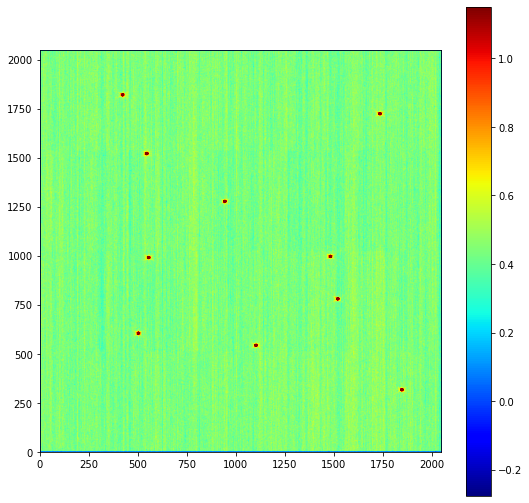

In [8]:
#show_image(path+filename, zscale=True, nsamples=10000)
show_image(file1, zscale=True, nsamples=10000)

With the image, one can look at the sources via the photutils routines.  This is what is done in generating the source catalogue within the pipeline.

In [10]:
from photutils import DAOStarFinder
import photutils.detection as detection
from photutils import data_properties
from astropy import units
from astropy import stats
#image = fits.getdata(path+filename, ext=1)
image = fits.getdata(file1, ext=1)
print('Input image: ', file1)

def find_sources(image, fwhm=1.4, nsigma=50.0, roundness=1.0, sharpness=0.1):
    mean, median, standard_deviation = stats.sigma_clipped_stats(image, sigma=3.0)
    newimage = image - median
    print('Median value %.3f subtracted from input image.\n' % (median))
    print('Image clipped standard deviation value: %f\n' % (standard_deviation))
    daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma*standard_deviation,
                            roundlo= -roundness, roundhi=roundness,
                            sharplo=sharpness)
    source_list = daofind(newimage) 
    print('DAOFind output values:')
    print('Number of sources found: ', len(source_list))
    print(' ')
    print(' id    xpixel     ypixel   sharpness  roundness1 roundness2  peak      flux')
    for loop in range(len(source_list)):
        print('%3d %10.3f %10.3f %7.3f     %7.3f     %7.3f %9.3f %10.3f' % (
            source_list['id'][loop], source_list['xcentroid'][loop], 
            source_list['ycentroid'][loop], source_list['sharpness'][loop], 
            source_list['roundness1'][loop], source_list['roundness2'][loop], 
            source_list['peak'][loop], source_list['flux'][loop]))
    print(' ')
    return source_list

source_list1 = find_sources(image, nsigma=150.0)

Input image:  /Users/cracraft/MIRI/jwst_validation_notebooks/jwst_validation_notebooks/image3/jwst_image3_niriss_test/jw01085002001_01101_00001_nis_simple_rate.fits
Median value 0.441 subtracted from input image.

Image clipped standard deviation value: 0.116748

DAOFind output values:
Number of sources found:  10
 
 id    xpixel     ypixel   sharpness  roundness1 roundness2  peak      flux
  1   1843.702    316.649   0.789       0.455      -0.096   547.655     27.436
  2   1100.516    542.741   0.852       0.128      -0.110   741.769     38.315
  3    501.636    604.732   0.779       0.482       0.010   535.542     26.728
  4   1517.212    779.473   0.893       0.462       0.183   853.972     43.801
  5    554.113    990.009   0.971      -0.023      -0.025  1283.729     65.500
  6   1479.656    995.834   0.837      -0.433      -0.377   723.921     37.872
  7    941.777   1276.124   0.952      -0.241      -0.130  1142.920     58.461
  8    544.110   1519.929   0.963      -0.004       0

In [11]:
#image1 = fits.getdata('./simple_dithered_imaging_example3/jw01085002001_01101_00001_nis_uncal_F158M_final_seed_image.fits', ext=1)
image1 = fits.getdata(file2, ext=1)
source_list2 = find_sources(image1, nsigma=1500000.0)


Median value 0.441 subtracted from input image.

Image clipped standard deviation value: 0.000039

DAOFind output values:
Number of sources found:  10
 
 id    xpixel     ypixel   sharpness  roundness1 roundness2  peak      flux
  1   1843.699    316.647   0.789       0.455      -0.096   538.650      8.183
  2   1100.519    542.745   0.857       0.130      -0.110   745.734     11.652
  3    501.632    604.744   0.781       0.499       0.023   518.337      7.815
  4   1517.213    779.477   0.893       0.468       0.185   832.307     12.933
  5    554.111    990.009   0.975      -0.023      -0.025  1272.206     19.639
  6   1479.654    995.835   0.838      -0.434      -0.377   723.605     11.477
  7    941.780   1276.124   0.955      -0.241      -0.127  1138.190     17.627
  8    544.110   1519.929   0.966      -0.001       0.009  1231.944     19.091
  9   1732.182   1723.099   0.959      -0.016      -0.106  1169.180     18.127
 10    420.838   1818.859   0.944       0.056       0.015  1

Comparison of the source lists shows that the pixel positions from the pipeline output image are very similar to the ones from the Mirage infinite S/N scene image.  The peak values are similar but slightly different.  The flux values are not the same.  

# Photometry Comparison

For a photometry comparions one needs to compare the output magnitudes in the source table to the input Mirage magitudes.  This is complicated by the default source catalogue picking up a lot of low S/N sources because the default is S/N of 3.0.  It is also of interest to look at a wider range of source brightnesses than is present in the above simulation where all 10 sources have the same input brightness.  One can see that the output flux or peak values above cover a factor of 2 even with the same input source brightness values in the simulation.  Clearly this is an issue.  It seems to be the direct result of DAOFind using a Gaussian kernel to approximate the undersampled, and clearly non-Gaussian, NIRISS point spread function.

In [12]:
def box_photometry(image, xpos, ypos, npix=10):
    sub1 = numpy.copy(image[ypos-npix: ypos+npix+1, xpos-npix: xpos+npix+1])
    npix1 = sub1.size
    sub2 = numpy.copy(image[ypos-2*npix: ypos+2*npix+1, xpos-2*npix:xpos+2*npix+1])
    npix2 = sub2.size
    signal1 = numpy.sum(sub1)
    signal2 = numpy.sum(sub2)
    background = (signal2 - signal1)*npix1/(npix2 - npix1)
    source_signal = signal1 - background
    return source_signal


outsignal1 = numpy.zeros((len(source_list1['xcentroid'])))
relmag1 = outsignal1*0.
print('# Source     Signal   Relative Magnitude')
for loop in range(len(source_list1['xcentroid'])):
    xpix = int(source_list1['xcentroid'][loop]+0.5)
    ypix = int(source_list1['ycentroid'][loop]+0.5)
    outsignal1[loop] = box_photometry(image1, xpix, ypix, 10)
    relmag1[loop] = 25.0 - 2.5*math.log10(outsignal1[loop])
    print('     %3d %12.3f  %10.5f' % (loop+1, outsignal1[loop], relmag1[loop]))
    
    

# Source     Signal   Relative Magnitude
       1     2823.422    16.37306
       2     2823.533    16.37302
       3     2825.501    16.37226
       4     2821.130    16.37394
       5     2823.508    16.37303
       6     2819.181    16.37469
       7     2821.391    16.37384
       8     2823.325    16.37310
       9     2819.943    16.37440
      10     2823.199    16.37315


In [13]:
outsignal2 = numpy.zeros((len(source_list2['xcentroid'])))
relmag2 = outsignal2*0.
print('# Source     Signal   Relative Magnitude    Delta Magnitude')
for loop in range(len(source_list2['xcentroid'])):
    xpix = int(source_list2['xcentroid'][loop]+0.5)
    ypix = int(source_list2['ycentroid'][loop]+0.5)
    outsignal2[loop] = box_photometry(image, xpix, ypix, 10)
    relmag2[loop] = 25.0 - 2.5*math.log10(outsignal2[loop])
    print('     %3d %12.3f  %10.5f          %10.5f' % (
        loop+1, outsignal2[loop], relmag2[loop], relmag1[loop] - relmag2[loop]))
print(' ')
delmag = relmag1 - relmag2
delmean = numpy.mean(delmag)
print('Mean magnitude difference: %.5f' % (delmean))
print('Range: %.5f to %.5f (total %.5f)' % (numpy.min(delmag), numpy.max(delmag), numpy.max(delmag) - numpy.min(delmag)))
print('Standard deviation of differences: %.5f' % (numpy.std(delmag)))

# Source     Signal   Relative Magnitude    Delta Magnitude
       1     2867.751    16.35615             0.01691
       2     2834.511    16.36880             0.00421
       3     2894.107    16.34621             0.02605
       4     2869.559    16.35546             0.01848
       5     2856.455    16.36043             0.01260
       6     2828.967    16.37093             0.00376
       7     2860.123    16.35904             0.01480
       8     2885.590    16.34941             0.02368
       9     2849.969    16.36290             0.01150
      10     2862.258    16.35823             0.01492
 
Mean magnitude difference: 0.01469
Range: 0.00376 to 0.02605 (total 0.02229)
Standard deviation of differences: 0.00688


So there are small variations in signal in the output ramp slope images with respect to the input Mirage scene image at the 0.004 to 0.026 magnitude level.

In [14]:
#image3 = fits.getdata('./simple_dithered_imaging_example3/run1/jw01085002001_01101_00001_nis_i2d.fits', ext=1)
image3 = fits.getdata(file3, ext=1)
source_list3 = find_sources(image3, nsigma=150.0)

Median value 0.307 subtracted from input image.

Image clipped standard deviation value: 0.057515

DAOFind output values:
Number of sources found:  10
 
 id    xpixel     ypixel   sharpness  roundness1 roundness2  peak      flux
  1   1836.702    318.635   0.768      -0.257      -0.140   351.504     35.210
  2   1096.508    549.256   0.805       0.751       0.313   366.251     36.375
  3    499.683    614.070   0.738      -0.065      -0.019   323.702     31.982
  4   1511.559    784.697   0.729       0.195       0.056   319.465     31.745
  5    552.222   1000.629   0.880       0.090       0.235   557.167     57.879
  6   1474.100   1002.434   0.755       0.107       0.007   335.972     33.764
  7    938.644   1286.218   0.812      -0.325      -0.605   452.222     47.868
  8    542.282   1532.759   0.807       0.715       0.476   421.600     43.743
  9   1725.887   1731.015   0.885      -0.268      -0.257   589.851     61.885
 10    419.463   1832.789   0.875      -0.102      -0.276   

In [15]:
outsignal3 = numpy.zeros((len(source_list2['xcentroid'])))
relmag3 = outsignal3*0.
print('# Source     Signal   Relative Magnitude    Delta Magnitude')
for loop in range(len(source_list3['xcentroid'])):
    xpix = int(source_list3['xcentroid'][loop]+0.5)
    ypix = int(source_list3['ycentroid'][loop]+0.5)
    outsignal3[loop] = box_photometry(image3, xpix, ypix, 10)
    relmag3[loop] = 25.0 - 2.5*math.log10(outsignal3[loop])
    print('     %3d %12.3f  %10.5f          %10.5f' % (
        loop+1, outsignal3[loop], relmag3[loop], relmag1[loop] - relmag3[loop]))
print(' ')
delmag = relmag1 - relmag3
delmean = numpy.mean(delmag)
print('Mean magnitude difference: %.5f' % (delmean))
print('Range: %.5f to %.5f (total %.5f)' % (numpy.min(delmag), numpy.max(delmag), numpy.max(delmag) - numpy.min(delmag)))
print('Standard deviation of differences: %.5f' % (numpy.std(delmag)))


# Source     Signal   Relative Magnitude    Delta Magnitude
       1     1995.210    16.75003            -0.37697
       2     1972.173    16.76264            -0.38962
       3     2012.684    16.74056            -0.36830
       4     1999.687    16.74759            -0.37365
       5     1987.824    16.75406            -0.38103
       6     1970.332    16.76365            -0.38896
       7     1990.683    16.75249            -0.37865
       8     2007.177    16.74354            -0.37044
       9     1984.357    16.75595            -0.38155
      10     1992.110    16.75172            -0.37857
 
Mean magnitude difference: -0.37877
Range: -0.38962 to -0.36830 (total 0.02132)
Standard deviation of differences: 0.00666


There is an overall signal offset (due to converting to MJy/ster from ADU/s) but the range remains fairly small.

In [16]:
from jwst.source_catalog import SourceCatalogStep
from astropy.io import ascii
#runpath1 = '/ifs/jwst/wit/niriss/kevin/simple_dithered_imaging_example3/run1/'
#resampledname1 = 'jw01085002001_01101_00001_nis_i2d.fits'
#resampledname2 = 'jw01085002001_01101_00001_nis_combined_i2d.fits'
resampledname1=file3
resampledname2=file4

result1 = SourceCatalogStep.call(
    resampledname1, npixels=30, snr_threshold=100.0, 
    save_results=True)
catalogue1 = ascii.read('jw01085002001_01101_00001_nis_simple_cat.ecsv')   ### Check which file this should use
print('# Source  Magnitude    Input Magnitude    Delta Magnitude')
for loop in range(len(catalogue1)):
    print('%3d      %10.5f      %10.5f      %10.5f' % (
        loop+1, catalogue1['aper70_vegamag'][loop], relmag1[loop], 
        relmag1[loop] - catalogue1['aper70_vegamag'][loop]))
print(' ')
delmag = relmag1 - catalogue1['aper70_vegamag']
delmean = numpy.mean(delmag)
print('Mean magnitude difference: %.5f' % (delmean))
print('Range: %.5f to %.5f (total %.5f)' % (numpy.min(delmag), numpy.max(delmag), numpy.max(delmag) - numpy.min(delmag)))
print('Standard deviation of differences: %.5f' % (numpy.std(delmag)))



2021-01-19 15:38:50,907 - CRDS - INFO -  Fetching  /Users/cracraft/crds_cache/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0003.rmap    1.8 K bytes  (1 / 25 files) (0 / 85.1 K bytes)
2021-01-19 15:38:51,068 - CRDS - INFO -  Fetching  /Users/cracraft/crds_cache/mappings/jwst/jwst_nirspec_extract1d_0012.rmap    1.2 K bytes  (2 / 25 files) (1.8 K / 85.1 K bytes)
2021-01-19 15:38:51,210 - CRDS - INFO -  Fetching  /Users/cracraft/crds_cache/mappings/jwst/jwst_nirspec_apcorr_0005.rmap    5.3 K bytes  (3 / 25 files) (3.1 K / 85.1 K bytes)
2021-01-19 15:38:51,352 - CRDS - INFO -  Fetching  /Users/cracraft/crds_cache/mappings/jwst/jwst_nirspec_0215.imap    4.8 K bytes  (4 / 25 files) (8.4 K / 85.1 K bytes)
2021-01-19 15:38:51,501 - CRDS - INFO -  Fetching  /Users/cracraft/crds_cache/mappings/jwst/jwst_niriss_saturation_0011.rmap      693 bytes  (5 / 25 files) (13.1 K / 85.1 K bytes)
2021-01-19 15:38:51,638 - CRDS - INFO -  Fetching  /Users/cracraft/crds_cache/mappings/jwst/jwst_niriss_pars-twe

AttributeError: 'WCS' object has no attribute 'cpdis1'

In [16]:
result2 = SourceCatalogStep.call(
    resampledname2, npixels=30, snr_threshold=100.0, 
    save_results=True)
catalogue2 = ascii.read('jw01085002001_01101_00001_nis_simple_combined_cat.ecsv')
print('# Source  Magnitude    Input Magnitude    Delta Magnitude')
for loop in range(len(catalogue1)):
    print('%3d      %10.5f      %10.5f      %10.5f' % (
        loop+1, catalogue2['aper70_vegamag'][loop], relmag1[loop], 
        relmag1[loop] - catalogue2['aper70_vegamag'][loop]))
print(' ')
delmag = relmag1 - catalogue2['aper70_vegamag']
delmean = numpy.mean(delmag)
print('Mean magnitude difference: %.5f' % (delmean))
print('Range: %.5f to %.5f (total %.5f)' % (numpy.min(delmag), numpy.max(delmag), numpy.max(delmag) - numpy.min(delmag)))
print('Standard deviation of differences: %.5f' % (numpy.std(delmag)))



2020-10-16 12:36:17,458 - CRDS - ERROR -  Error determining best reference for 'pars-sourcecatalogstep'  =   Unknown reference type 'pars-sourcecatalogstep'


# Source  Magnitude    Input Magnitude    Delta Magnitude
  1        17.61459        16.37306        -1.24152
  2        17.53688        16.37302        -1.16387
  3        17.53432        16.37226        -1.16206
  4        17.62167        16.37394        -1.24772
  5        17.56586        16.37303        -1.19284
  6        17.38372        16.37469        -1.00902
  7        17.66110        16.37384        -1.28726
  8        17.65435        16.37310        -1.28125
  9        17.64159        16.37440        -1.26719
 10        17.66894        16.37315        -1.29579
 
Mean magnitude difference: -1.21485
Range: -1.29579 to -1.00902 (total 0.28676)
Standard deviation of differences: 0.08305


Note that the range of magnitude values out is several times larger for the combined image than for the individual input resampled image.  The standard deviation value is likewise about a factor of 5.4 larger in the combined resampled image than in the individual image.  The mean magnitude difference has changed by 0.4155 magnitudes or a factor of 0.682.  This is a problem in the pipeline; the units are the same for both resampled images and so the signal should be the same in the two cases.  The aperture corrections outside the 21x21 source box used should be much smaller than this 0.682 factor.

## Comparison With Input Magnitudes (Complex Case)

A better practical comparison is to input a more realistic source catalogue and see how the output catalogue and the input catalogue compare.  This has been done in a separate simulation wherein the same field is used but the input source catalogue to Mirage is generated based on the Gaia DR2 data for the area.  The output files for that run are found at

/ifs/jwst/wit/niriss/kevin/complex_dithered_imaging_example

or on box at https://stsci.app.box.com/folder/118342131866 under the complex_dithered_imaging_example directory.

The creation of the simulations is the same as in the simpler case, only the source catalogue input to Mirage is different.  They are then run through the pipeline in the same way as the simple case was.  Comparison of the output catalogue to the input catalogue will be done with the files in the run1 sub-directory.

cpath = './complex_dithered_imaging_example/run1/'
cimagename = 'jw01085002001_01101_00001_nis_rate.fits'
show_image(cpath+cimagename, zscale=True)

2020-10-16 12:41:47,432 - CRDS - ERROR -  Error determining best reference for 'pars-sourcecatalogstep'  =   Unknown reference type 'pars-sourcecatalogstep'


# Number of detected sources:  165
# Original catalogue: 977 sources
# Detection ratio: 16.888%


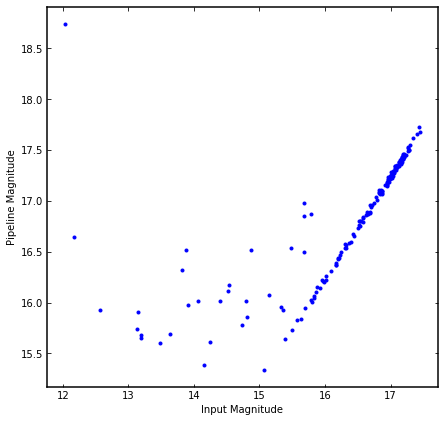

In [18]:
#cpath = './complex_dithered_imaging_example/run1/'
#cname = 'jw01085002001_01101_00001_nis_i2d.fits'

def arc_distance(ra1, dec1, ra2, dec2):
    c1 = SkyCoord(ra1, dec1, unit='deg')
    c2 = SkyCoord(ra2, dec2, unit='deg')
    sep = c1.separation(c2)
    arcdist = sep.arcsec
    return arcdist

def position_angle(ra1, dec1, ra2, dec2):
    dtor = 3.141592653589793238/180.
    angles = numpy.arctan2(numpy.sin((ra2 - ra1)*dtor), 
                           math.cos(dec1*dtor)*numpy.tan(dec2*dtor) - 
                           math.sin(dec1*dtor)*numpy.cos((ra2 - ra1)*dtor))/dtor
    inds = numpy.where(angles < 0.)
    angles[inds] = angles[inds] + 360.0
    return angles

def tally_sources(imagename, npix, snr, outname='tally1'):
    cat1 = SourceCatalogStep.call(imagename, npixels=npix, snr_threshold=snr, 
        save_results=True, output_file=outname)
    catalogue1 = ascii.read(outname + '_cat.ecsv')
    nout = len(catalogue1)
    print('# Number of detected sources: ',nout)
    #invalues = numpy.loadtxt('./complex_dithered_imaging_example/jw01085002001_01101_00001_nis_uncal_pointsources.list', 
    #    comments=['#', ], usecols=[3, 4, 5, 6, 7])
    invalues = numpy.loadtxt('./complex_dithered_imaging_example/jw01085002001_01101_00001_nis_uncal_pointsources.list', 
        comments=['#', ], usecols=[3, 4, 5, 6, 7])
    sh1 = invalues.shape
    print('# Original catalogue: %d sources' % (sh1[0]))
    print('# Detection ratio: %.3f%s' % ((100.*float(nout)/sh1[0]), '%'))
    rain = numpy.squeeze(invalues[:, 0])
    decin = numpy.squeeze(invalues[:, 1])
    xpixin = numpy.squeeze(invalues[:, 2])
    ypixin = numpy.squeeze(invalues[:, 3])
    magsin = numpy.squeeze(invalues[:, 4])
    raout = numpy.copy(catalogue1['sky_centroid'].ra.value)
    decout = numpy.copy(catalogue1['sky_centroid'].dec.value)
    xpixout = numpy.copy(catalogue1['xcentroid'].value)
    ypixout = numpy.copy(catalogue1['ycentroid'].value)
    magsout = numpy.copy(catalogue1['aper70_vegamag'])
    matchinds = numpy.zeros((nout, 2), dtype=numpy.int16)
    radius1 = numpy.zeros_like(raout)
    theta1 = numpy.zeros_like(raout)
    radius2 = radius1*0.
    theta2 = theta1*0.
    dtor = 3.141592653589793238/180.
    for loop in range(nout):
        separation1 = arc_distance(raout[loop], decout[loop], rain, decin)
        angle1 = position_angle(raout[loop], decout[loop], rain, decin)
        n = numpy.argmin(separation1)
        separation2 = numpy.sqrt((xpixout[loop] - xpixin)**2 + 
                                 (ypixout[loop] - ypixin)**2)
        angle2 = numpy.arctan2((ypixout[loop] - ypixin), (xpixout[loop] - xpixin))
        angle2 = angle2/dtor
        m = numpy.argmin(separation2)
        matchinds[loop, 0] = n
        matchinds[loop, 1] = m
        radius1[loop] = separation1[n]
        theta1[loop] = angle1[n]
        radius2[loop] = separation2[m]
        theta2[loop] = angle2[m]
    return rain, decin, xpixin, ypixin, magsin, raout, decout, xpixout, ypixout, \
        magsout, matchinds, radius1, theta1, radius2, theta2

def basic_plot(xdata, ydata, width=1.0, colour='blue', symbol=None, size=2.0, labels=['', ''], 
               title = None, prange=[None, None, None, None], linedatavalues = [None, None]):
    pyplot.figure(1, figsize=(7., 7.))
    axes = pyplot.subplot(111)
    if symbol is None:
        pyplot.plot(xdata, ydata, color=colour, linewidth=width)
    else:
        pyplot.plot(xdata, ydata, linestyle='None', color=colour, marker=symbol, markersize=size)
    if title is not None:
       pyplot.title(title)
    if linedatavalues[0] is not None:
        pyplot.plot(linedatavalues[0], linedatavalues[1], color='black', linewidth=1.0, linestyle='dashed')
    pyplot.xlabel(labels[0])
    pyplot.ylabel(labels[1])
    pyplot.tick_params(axis='x', direction='in')
    pyplot.tick_params(axis='y', direction='in')
    axes.tick_params(bottom=True, top=True, which='both')
    axes.tick_params(right=True, left=True, which='both')
    axes.spines['bottom'].set_linewidth(1.5)
    axes.spines['top'].set_linewidth(1.5)
    axes.spines['left'].set_linewidth(1.5)
    axes.spines['right'].set_linewidth(1.5)
    if prange[0] is not None:
        axes.set_xbound(prange[0], prange[1])
        axes.set_ybound(prange[2], prange[3])
    pyplot.show()
    

#rain, decin, xpixin, ypixin, magsin, raout, decout, xpixout, ypixout, magsout, \
#    matchinds, radius1, theta1, radius2, theta2 = tally_sources(cpath+cname, 30, 100.0)

rain, decin, xpixin, ypixin, magsin, raout, decout, xpixout, ypixout, magsout, \
    matchinds, radius1, theta1, radius2, theta2 = tally_sources(file5, 30, 100.0)

yvalues1 = numpy.copy(magsout)
inds1 = numpy.squeeze(matchinds[:,0])
inds2 = numpy.squeeze(matchinds[:,1])
xvalues1 = numpy.copy(magsin[inds1])
basic_plot(xvalues1, yvalues1, size=3.0, colour='blue', symbol='o', labels=['Input Magnitude', 'Pipeline Magnitude'])


The plot above shows the closest RA/Dec matches.  One sees that there is a match for a number of sources with a tight correlation and then scattter of objects with larger input magnitudes than output ones.  One would like to examine only the ones with a reasonable correlation.  The fraction of sources detected is relatively low but it probably is a pure S/N effect.

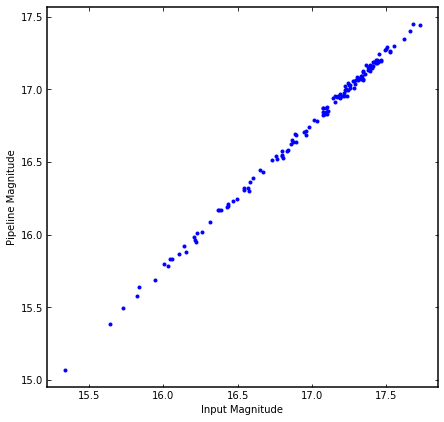

In [19]:
delmag1 = magsout - magsin[inds1]
rawmags = numpy.copy(magsin[inds1])
cinds = numpy.where(delmag1 < 0.5)
xvalues2 = numpy.copy(magsout[cinds])
yvalues2 = numpy.copy(rawmags[cinds])
basic_plot(xvalues2, yvalues2, size=3.0, colour='blue', symbol='o', labels=['Input Magnitude', 'Pipeline Magnitude'])



Best fit slope: 0.99556 +/- 0.17248
Best fit intercept: -0.16222 +/- 2.92772 
RMS deviation from line = 0.021143
Parameter covariance: -0.50475, correlation: -0.99956


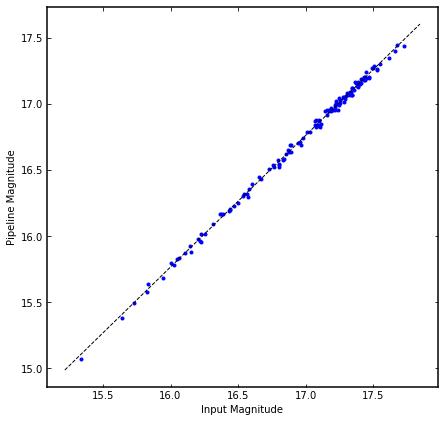

In [20]:
def slope_calculation(xdata, ydata, yerrors=None):
    """
    Calculate a standard least-squares linear fit to input data.  

    This is for the case where the standard library function fails, as is 
    found to be the case in some instances.

    The treatment is as in "Numerical Recipes in C" (second edition) section
    15.2.

    Parameters
    ----------

    xdata:  A one-dimensional numpy float or integer array of the x values

    ydata:  A one-dimensional numpy float or integer array of the y values,
            which must be the same length as the xdata array

    yerrors:  An optional one-dimensional numpy float array of the y value 
              uncertainties, which must be the same length as the xdata array 
              if defined.  If not defined, the values are set to a constant.  
              The error values must be strictly positive, non-zero.

    Returns
    -------

    slope:           A float value, the best fit slope

    intercept:       A float value, the best fit intercept

    slopeerror:      A float value, the uncertainty in the best fit slope 
                     (standard deviation estimate)

    intercepterror:  A float value, the uncertainty in the best fit intercept
                     (standard deviation estimate)

    covariance:      A float value, the covariance between the fit parameters

    correlation:     A float value, the correlation coefficient of the fit

    """
    if yerrors is None:
        yerrors = ydata*0. + 1.
    else:
        inds = numpy.where(yerrors > 0.)
        mean1 = numpy.mean(yerrors[inds])
        inds = numpy.where(yerrors <= 0.)
        yerrors[inds] = mean1
    if (xdata.shape != ydata.shape) or (len(xdata.shape) > 1) or \
       (xdata.shape != yerrors.shape):
        return None, None, None, None, None, None
    invvariance = 1./(yerrors*yerrors)
    sum1 = numpy.sum(invvariance)
    sum2 = numpy.sum(xdata*invvariance)
    sum3 = numpy.sum(ydata*invvariance)
    xmean = sum2/sum1
    t1 = (xdata - xmean)/ yerrors
    sum4 = numpy.sum(t1*t1)
    slope = numpy.sum(t1*ydata/yerrors)/sum4
    intercept = (sum3 - (slope*sum2))/sum1
    interceptvariance = (1. + (sum2*sum2)/(sum1*sum4))/sum1
    slopevariance = 1./sum4
    covariance = -1.*sum2/(sum1*sum4)
    correlation = covariance/numpy.sqrt(slopevariance*interceptvariance)
    return slope, intercept, math.sqrt(slopevariance), \
        math.sqrt(interceptvariance), covariance, correlation

slope, intercept, slopeerr, intercepterr, covariance, correlation = slope_calculation(xvalues2, yvalues2)
print('Best fit slope: %.5f +/- %.5f' % (slope, slopeerr))
print('Best fit intercept: %.5f +/- %.5f ' % (intercept, intercepterr))
rms = math.sqrt(numpy.mean((yvalues2 - (slope*xvalues2 + intercept))**2))
print('RMS deviation from line = %f' % (rms))
print('Parameter covariance: %.5f, correlation: %.5f' % (covariance, correlation))
xmin = numpy.min(xvalues2)
xmax = numpy.max(xvalues2)
delx = (xmax - xmin)
magvalues = numpy.arange(xmin-delx/20., xmax+delx/10., delx/20.)
fitvalues = intercept + slope*magvalues
basic_plot(xvalues2, yvalues2, size=3.0, colour='blue', symbol='o', 
           labels=['Input Magnitude', 'Pipeline Magnitude'], linedatavalues=[magvalues, fitvalues])


The best fit slope is consistent with 1.0, but there is an overall offset.  The RMS deviation seems reasonable.

In [21]:
line_offset = numpy.mean(yvalues2) - numpy.mean(xvalues2)
print(line_offset)

-0.2375994179104488


The offset above is what one would get if one fit a line of slope 1.0 to the data values.

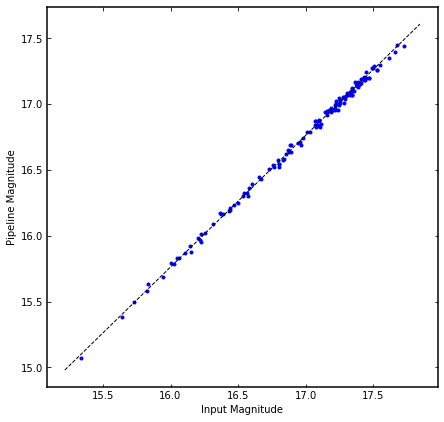

Unit slope RMS = 0.02126


In [22]:
newfitvalues = line_offset + magvalues
basic_plot(xvalues2, yvalues2, size=3.0, colour='blue', symbol='o', 
           labels=['Input Magnitude', 'Pipeline Magnitude'], linedatavalues=[magvalues, newfitvalues])
altrms = numpy.sqrt(numpy.mean((yvalues2 - line_offset - xvalues2)**2))
print('Unit slope RMS = %.5f' % (altrms))


## Magnitude Comparison on the Combined Resampled Image

One can carry out the same type of calculations for the combined final image.  In this case only the unit slope line will be calculated since the individual image magnitude comparison was consistent with a slope of 1 within the uncertainties.

In [23]:
#cpath1 = './complex_dithered_imaging_example/run1/'
#cname1 = 'jw01085002001_01101_00001_nis_combined_i2d.fits'
#arain, adecin, axpixin, aypixin, amagsin, araout, adecout, axpixout, aypixout, amagsout, \
#    amatchinds, aradius1, atheta1, aradius2, atheta2 = tally_sources(cpath1+cname1, 30, 100.0, 'tally2')
arain, adecin, axpixin, aypixin, amagsin, araout, adecout, axpixout, aypixout, amagsout, \
    amatchinds, aradius1, atheta1, aradius2, atheta2 = tally_sources(file6, 30, 100.0, 'tally2')

ayvalues1 = numpy.copy(amagsout)
ainds1 = numpy.squeeze(amatchinds[:,0])
ainds2 = numpy.squeeze(amatchinds[:,1])
axvalues1 = numpy.copy(amagsin[ainds1])
adelmag1 = amagsout - amagsin[ainds1]
arawmags = numpy.copy(amagsin[ainds1])
acinds = numpy.where(adelmag1 < 1.0)
axvalues2 = numpy.copy(amagsout[acinds])
ayvalues2 = numpy.copy(arawmags[acinds])
alt_line_offset = numpy.mean(ayvalues2) - numpy.mean(axvalues2)
print('Intercept Offset: ', alt_line_offset)
xmin1 = numpy.min(axvalues2)
xmax1 = numpy.max(axvalues2)
delx1 = (xmax1 - xmin1)
magvalues1 = numpy.arange(xmin1-delx1/20., xmax1+delx1/10., delx1/20.)
newfitvalues1 = alt_line_offset + magvalues1
altrms1 = numpy.sqrt(numpy.mean((ayvalues2 - alt_line_offset - axvalues2)**2))
print('Unit slope RMS = %.5f' % (altrms1))



2020-10-16 12:41:55,430 - CRDS - ERROR -  Error determining best reference for 'pars-sourcecatalogstep'  =   Unknown reference type 'pars-sourcecatalogstep'


# Number of detected sources:  217
# Original catalogue: 977 sources
# Detection ratio: 22.211%
Intercept Offset:  -0.738104542857144
Unit slope RMS = 0.15829


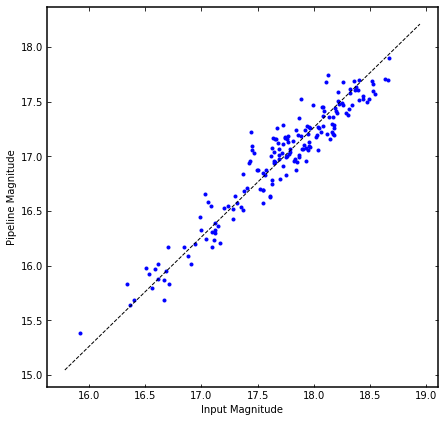

In [24]:
basic_plot(axvalues2, ayvalues2, size=3.0, colour='blue', symbol='o', 
           labels=['Input Magnitude', 'Pipeline Magnitude'], linedatavalues=[magvalues1, newfitvalues1])

Now the unit slope RMS value is 0.158 which is significantly higher than in the individual image case.

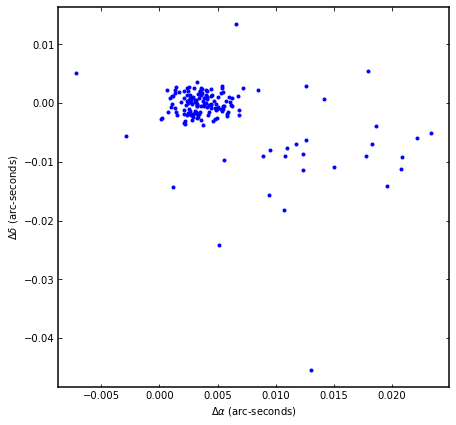

In [25]:
dtor = math.radians(1.)
delra1 = radius1*numpy.sin(theta1*dtor)
deldec1 = radius1*numpy.cos(theta1*dtor)
basic_plot(delra1, deldec1, size=3.0, colour='blue', symbol='o', 
           labels=[r'$\Delta\alpha$ (arc-seconds)', r'$\Delta\delta$ (arc-seconds)'])


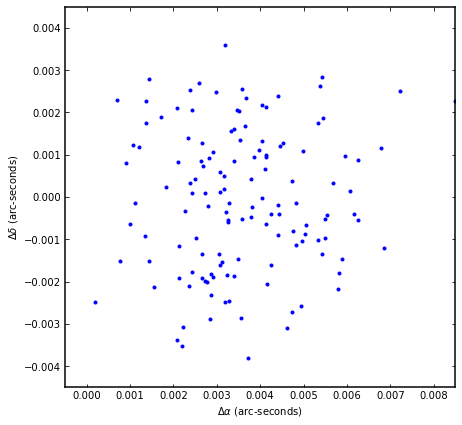

In [26]:
delra1a = radius1[cinds]*numpy.sin(theta1[cinds]*dtor)
deldec1a = radius1[cinds]*numpy.cos(theta1[cinds]*dtor)
basic_plot(delra1a, deldec1a, size=3.0, colour='blue', symbol='o',
          labels=[r'$\Delta\alpha$ (arc-seconds)', r'$\Delta\delta$ (arc-seconds)'],
          prange=[-0.0005, 0.0085, -0.0045, 0.0045])




The above plot shows the position offsets for the objects with smaller magnitude offsets, and the scatter is roughly within 0.1 pixel.  The previous plot with all matches shows larger position offsets in the other matches where the magnitudes also are discrepant.  Hence those are probably just bad matches.  Exactly why these are bad matches is not clear from the data at hand.  One would need to look more carefully at the catalogue outputs in the images.

The distribution fits within a pixel but note that the delta RA values average out at about +0.06 pixels off zero whereas the delta Dec values average out close to zero.

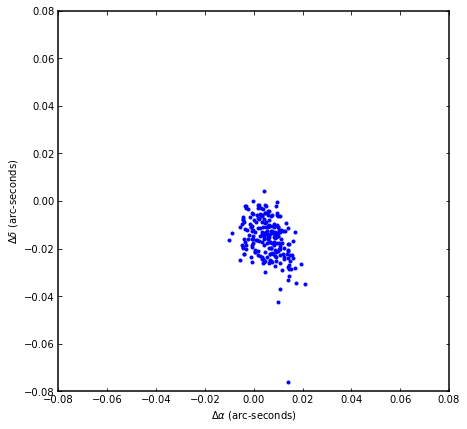

In [27]:
delra2 = aradius1*numpy.sin(atheta1*dtor)
deldec2 = aradius1*numpy.cos(atheta1*dtor)
basic_plot(delra2, deldec2, size=3.0, colour='blue', symbol='o', 
           labels=[r'$\Delta\alpha$ (arc-seconds)', r'$\Delta\delta$ (arc-seconds)'],
           prange=[-0.08, 0.08, -0.08, 0.08])


The above plot shows the position matches for the combined image.  Here there is a small offset from zero in the overall position differences, but it is larger than before and in the minus declination direction.